# Test simple convolution kernel training.

In [71]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor, Resize, Grayscale
from PIL import Image

In [2]:
SEED = 0
IMAGE_PATH = "img.jpg"

In [101]:
def make_conv2d(in_channels):
    return torch.nn.Conv2d(in_channels=in_channels,
                           out_channels=1,
                           kernel_size=3)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_path=None, resize=None, grayscale=False):
        if image_path is not None:
            self.image = Image.open(image_path)
        else:
            np.random.seed(SEED)
            self.image = Image.fromarray(np.uint8(np.random.random((800, 1280, 3)) * 255))
        self._transforms = []
        if resize is not None:
            self._transforms.append(Resize(resize, Image.NEAREST))
        if grayscale:
            self._transforms.append(Grayscale())
        self._grayscale = grayscale
        self._transforms.append(ToTensor())
        
        self.conv = make_conv2d(in_channels=self.num_channels)
        torch.manual_seed(SEED)
        self.conv.weight.data[:] = torch.rand_like(self.conv.weight)
        self.conv.bias.data[:] = torch.rand_like(self.conv.bias)
        for name, param in self.conv.named_parameters():
            param.requires_grad = False
        self._parameters = dict(self.conv.named_parameters())
    
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        image = self.image
        for transform in self._transforms:
            image = transform(image)
        target = self.conv(image.unsqueeze(0))[0]
        return image, target
    
    @property
    def num_channels(self):
        return 1 if self._grayscale else len(self.image.getbands())

    @property
    def kernel(self):
        return self._parameters["weight"]
    
    @property
    def bias(self):
        return self._parameters["bias"]


class ConvModel(torch.nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv = make_conv2d(input_channels)
        self._parameters = dict(self.conv.named_parameters())
        
    def forward(self, batch):
        result = self.conv(batch)
        return result
    
    @property
    def kernel(self):
        return self._parameters["weight"]
    
    @property
    def bias(self):
        return self._parameters["bias"]
    
    
def train(data, num_steps=1000, learning_rate=1e-1):
    model = ConvModel(input_channels=data.num_channels)
    loss_fn = torch.nn.modules.loss.MSELoss(reduction="mean")
    model.train()
    for i in range(num_steps):
        image, target = data[0]
        prediction = model(image.unsqueeze(0))[0]
        loss = loss_fn(prediction, target)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param.data -= learning_rate * param.grad
        if i % 100 == 0:
            print("Loss: {:.5f}, delta kernel: {:.5f}, delta bias: {:.5f}".format(
                loss.item(),
                (model.kernel - data.kernel).abs().mean().item(),
                (model.bias - data.bias).abs().mean().item()))

# Real image
Kernel reconstruction fails for real image.

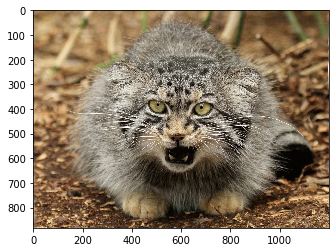

In [102]:
data = Dataset(IMAGE_PATH)
plt.imshow(data[0][0].numpy().transpose(1, 2, 0))
plt.show()

In [103]:
train(data)

Loss: 41.94051, delta kernel: 0.27589, delta bias: 1.04851
Loss: 0.00661, delta kernel: 0.23690, delta bias: 0.05368
Loss: 0.00258, delta kernel: 0.22762, delta bias: 0.01406
Loss: 0.00136, delta kernel: 0.22164, delta bias: 0.00960
Loss: 0.00085, delta kernel: 0.21758, delta bias: 0.00774
Loss: 0.00058, delta kernel: 0.21461, delta bias: 0.00646
Loss: 0.00042, delta kernel: 0.21232, delta bias: 0.00550
Loss: 0.00032, delta kernel: 0.21077, delta bias: 0.00476
Loss: 0.00026, delta kernel: 0.20969, delta bias: 0.00418
Loss: 0.00021, delta kernel: 0.20876, delta bias: 0.00370


# Random image
Random image leads to fast kernel reconstruction.

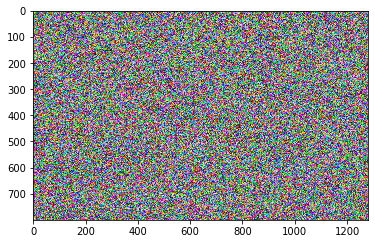

In [104]:
data = Dataset()
plt.imshow(data[0][0].numpy().transpose(1, 2, 0))
plt.show()

In [105]:
train(data)

Loss: 48.34929, delta kernel: 0.28648, delta bias: 1.23010
Loss: 0.01151, delta kernel: 0.05705, delta bias: 0.59575
Loss: 0.00310, delta kernel: 0.03538, delta bias: 0.48091
Loss: 0.00186, delta kernel: 0.02856, delta bias: 0.38819
Loss: 0.00121, delta kernel: 0.02305, delta bias: 0.31334
Loss: 0.00079, delta kernel: 0.01861, delta bias: 0.25292
Loss: 0.00051, delta kernel: 0.01502, delta bias: 0.20415
Loss: 0.00033, delta kernel: 0.01212, delta bias: 0.16478
Loss: 0.00022, delta kernel: 0.00979, delta bias: 0.13301
Loss: 0.00014, delta kernel: 0.00790, delta bias: 0.10736


# Real grayscale image
Color image has high correlation between channels. Grayscale image is better for kernel reconstruction.

Images delta is low, but final kernel is far from original.

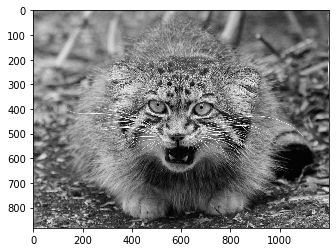

In [106]:
data = Dataset(IMAGE_PATH, grayscale=True)
plt.imshow(np.tile(data[0][0].numpy().transpose(1, 2, 0), (1, 1, 3)))
plt.show()

In [107]:
train(data)

Loss: 9.84331, delta kernel: 0.25398, delta bias: 0.17804
Loss: 0.00064, delta kernel: 0.13960, delta bias: 0.02897
Loss: 0.00044, delta kernel: 0.13224, delta bias: 0.00412
Loss: 0.00038, delta kernel: 0.12587, delta bias: 0.00098
Loss: 0.00033, delta kernel: 0.11998, delta bias: 0.00053
Loss: 0.00029, delta kernel: 0.11450, delta bias: 0.00041
Loss: 0.00026, delta kernel: 0.10937, delta bias: 0.00033
Loss: 0.00023, delta kernel: 0.10458, delta bias: 0.00027
Loss: 0.00021, delta kernel: 0.10009, delta bias: 0.00021
Loss: 0.00019, delta kernel: 0.09589, delta bias: 0.00016


# Scaled real grayscale image
Original image is blured. Scaling down with NEAREST interpolation produces images without blur.

Kernel reconstruction works well.

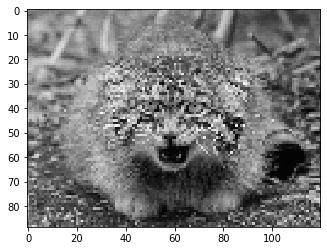

In [111]:
data = Dataset(IMAGE_PATH, resize=(89, 120), grayscale=True)
plt.imshow(np.tile(data[0][0].numpy().transpose(1, 2, 0), (1, 1, 3)))
plt.show()

In [112]:
train(data)

Loss: 9.64733, delta kernel: 0.26201, delta bias: 0.17682
Loss: 0.00205, delta kernel: 0.11475, delta bias: 0.05290
Loss: 0.00104, delta kernel: 0.08853, delta bias: 0.01113
Loss: 0.00062, delta kernel: 0.06905, delta bias: 0.00193
Loss: 0.00039, delta kernel: 0.05424, delta bias: 0.00022
Loss: 0.00025, delta kernel: 0.04323, delta bias: 0.00078
Loss: 0.00016, delta kernel: 0.03509, delta bias: 0.00093
Loss: 0.00011, delta kernel: 0.02865, delta bias: 0.00095
Loss: 0.00007, delta kernel: 0.02352, delta bias: 0.00092
Loss: 0.00005, delta kernel: 0.01980, delta bias: 0.00085
